### Import libraries

In [3]:
import QuantLib as ql
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


### Customize

In [4]:

# Provide name of the CSV file to save/load the raw data
my_raw_data='0506 quantlib_raw_data.csv'

# Provide name of the CSV file to save the simulated data
my_simulated_data='0506 quantlib_simulated_data.csv'

# Provide name of the png file to save histogram 
my_simulation_plot="0506 simulated_returns_histogram.png"

# Provide number of days to compute return
return_days=10

# Number of days in a year to annualize the values 
annual_working_days=252

# Provide the annual dividend rate (0r income from asset other than increase in price)
my_div=0.00

# Provide number of days to forecast
my_future_days=50

# Provide number of simulation runs
simulation_runs=10000

### Load data and initial setup

In [5]:
# Load the  file into a DataFrame
data = pd.read_csv(my_raw_data, index_col='Date', parse_dates=True)

# Set the evaluation date
today = ql.Date.todaysDate()
ql.Settings.instance().evaluationDate = today

close_prices = data['Close']


C:\Users\ahmed\AppData\Local\Temp\ipykernel_23896\3554651159.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data = pd.read_csv(my_raw_data, index_col='Date', parse_dates=True)


### Compute  return and volatility

In [6]:
# Compute initial  level
initial_index_level = close_prices.iloc[-1]

# Compute return over the specified period
if len(close_prices) >= return_days:
    period_return = np.log(close_prices.iloc[-1] / close_prices.iloc[-return_days])
else:
    raise ValueError("Not enough historical data to compute return for the specified period.")

# Compute volatility over the same period
volatility = close_prices.pct_change().dropna().std() * np.sqrt(annual_working_days)

### Setup parameters

In [7]:
# Market data setup
day_count = ql.Actual365Fixed()
calendar = ql.UnitedStates(ql.UnitedStates.NYSE)

# Simulation parameters
horizon = my_future_days  # Number of future days
num_paths = simulation_runs  # Number of Monte Carlo simulations

# Construct QuantLib objects using the period return instead of annual return
spot_handle = ql.QuoteHandle(ql.SimpleQuote(initial_index_level))
flat_ts = ql.YieldTermStructureHandle(ql.FlatForward(today, ql.QuoteHandle(ql.SimpleQuote(period_return)), day_count))
div_yield = ql.YieldTermStructureHandle(ql.FlatForward(today, ql.QuoteHandle(ql.SimpleQuote(my_div)), day_count))
flat_vol_ts = ql.BlackVolTermStructureHandle(ql.BlackConstantVol(today, calendar, ql.QuoteHandle(ql.SimpleQuote(volatility)), day_count))

# Define the stochastic process
stochastic_process = ql.BlackScholesMertonProcess(spot_handle, div_yield, flat_ts, flat_vol_ts)

### Setup Monte Carlo simulation 

In [8]:
# Monte Carlo simulation setup
rng = ql.GaussianRandomSequenceGenerator(
    ql.UniformRandomSequenceGenerator(horizon, ql.UniformRandomGenerator())
)
sequence_generator = ql.GaussianPathGenerator(stochastic_process, horizon / annual_working_days, horizon, rng, False)

# Generate simulation paths
index_levels = np.zeros((num_paths, horizon))

for i in range(num_paths):
    sample_path = sequence_generator.next()
    path = sample_path.value()
    index_levels[i, :] = np.array([path[j] for j in range(horizon)])  # Storing simulated values

### Save simulated data

In [9]:
# Create DataFrame
simulation_df = pd.DataFrame(index_levels, columns=[f"Day {i+1}" for i in range(horizon)])

# Add simulation run number as the first column
simulation_df.insert(0, "Simulation Run Number", np.arange(1, num_paths + 1))

# Save to CSV
simulation_df.to_csv(my_simulated_data, index=False)


### Plot histogram return for each simulation 

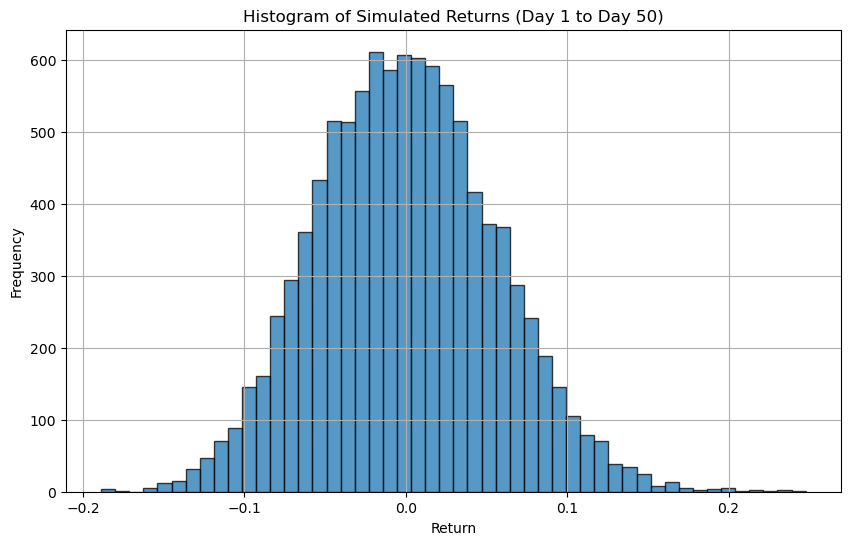

In [10]:
# Create dynamic column name
final_day_col = f"Day {my_future_days}"

# Calculate returns from Day 1 to the final day
day_1_prices = simulation_df["Day 1"]
final_day_prices = simulation_df[final_day_col]
returns = (final_day_prices - day_1_prices) / day_1_prices

# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(returns, bins=50, edgecolor='black', alpha=0.75)
plt.title(f"Histogram of Simulated Returns (Day 1 to Day {my_future_days})")
plt.xlabel("Return")
plt.ylabel("Frequency")
plt.grid(True)

# Save the histogram as PNG
plt.savefig(my_simulation_plot)

# Show plot
plt.show()



### Confirm saving files

In [11]:
print(f"Histogram saved as {my_simulation_plot}")
print(f"Monte Carlo simulation completed using a {return_days}-day return.")
print(f"Results saved to {my_simulated_data}.")

Histogram saved as 0506 simulated_returns_histogram.png
Monte Carlo simulation completed using a 10-day return.
Results saved to 0506 quantlib_simulated_data.csv.
